# Discovering Fair Principal Components

This notebook demonstrates the usage of Adversarial Principal Component Analysis (PCA), a method designed to remove confounding variables from the latent space representation. This technique is useful when we want to ensure that the extracted components are not influenced by confounders such as age, gender, or other demographic variables.

In this demonstration, we will:

1. Generate synthetic data with confounders.
2. Perform traditional PCA.
3. Apply Adversarial PCA to eliminate the confounding effect from the latent space.

We will visualize the latent space with each PCA model after being fit

## Load imports

We begin by loading the necessary libraries, including NumPy for data generation, `PCA` from _scikit-learn_ for traditional principal component analysis, and the custom implementation of adversarial PCA  `PPCAadversarial` from _bystro_.

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats import ortho_group


import matplotlib.pyplot as plt

from bystro.supervised_ppca.ppca_augmented import PPCAadversarial,PPCAadversarialRandomized

## Synthetic Data

### Generate synthetic data

We will now generate synthetic data to simulate a scenario with confounding variables. The data generation mechanism is as follows:

- **Latent Factors**: We simulate 3 latent factors that are responsible for generating the main data.
- **Confounders**: We introduce 4 confounders (e.g., age, demographic information), which will affect the observed data.
- **Noise**: Both the data and the confounders are perturbed by Gaussian noise to simulate real-world data variability.

The data is generated according to the following steps:

1. Generate latent factors from a multivariate normal distribution.
2. Combine the latent factors with an orthogonal weight matrix to create the noiseless data.
3. Generate confounders that are influenced by the latent factors.
4. Add noise to both the data and the confounders to simulate noisy observations.
5. Return the final dataset, including the observed features, confounder labels, and the true latent factors.
This generated dataset will be used for demonstrating how adversarial PCA can remove the influence of confounders.

In [2]:
def generate_data(sample_size=10000,
                  data_dim=80,
                  latent_dim=3,
                  confounder_dim=4,
                  noise_data=.5,
                  noise_confounder=.1,
                  seed=2021):
    rng = np.random.default_rng(seed)
    W_o = ortho_group.rvs(data_dim,random_state=seed)
    D_o = ortho_group.rvs(confounder_dim,random_state=seed+1)
    W = W_o[:,:latent_dim].T
    D = D_o[:,:latent_dim].T
    D[1:] = 0
    
    W[0] *= 2
    
    
    factors = rng.normal(size=(sample_size,latent_dim))
    
    X_nonoise = np.dot(factors,W)
    Y = np.dot(1*(factors>0),D) # Make this a binary label
    
    X_noise = rng.normal(size=(sample_size,data_dim))*noise_data
    Y_noise = rng.normal(size=(sample_size,confounder_dim))*noise_confounder
    X = X_nonoise + X_noise
    
    return X,Y,W,D,factors


## Visualizing Latent space

The next step is to visualize the latent space. We will plot the first two principal components and color the points by group (confounder label). This visualization will help us understand how the confounders influence the latent space representation.

In [3]:
def plot_pca_latent_space(S_adv, group_idx, 
                          xlabel='First Principal Component', 
                          ylabel='Second Principal Component', 
                          title='PCA Latent Space', 
                          fontsize_title=24, 
                          fontsize_labels=20, 
                          fontsize_legend=14, 
                          point_size=10,
                          legend_point_size=50):
    plt.figure(figsize=(8,6))
    
    # Scatter plot for two groups with regular point size
    scatter1 = plt.scatter(S_adv[group_idx==1,0], S_adv[group_idx==1,1], 
                           c='navy', s=point_size, label='Group 1', alpha=0.7)
    scatter2 = plt.scatter(S_adv[group_idx==0,0], S_adv[group_idx==0,1], 
                           c='gold', s=point_size, label='Group 2', alpha=0.7)
    
    # Labels and Title
    plt.xlabel(xlabel, fontsize=fontsize_labels)
    plt.ylabel(ylabel, fontsize=fontsize_labels)
    plt.title(title, fontsize=fontsize_title)
    
    # Creating custom legend with larger point size
    plt.legend([scatter1, scatter2], ['Group 1', 'Group 2'], 
               scatterpoints=1, loc='upper right', fontsize=fontsize_legend, 
               markerscale=legend_point_size/point_size)
    
    # Style adjustments: borders, bolder axes, removing top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    
    plt.tight_layout()
    plt.show()

In [4]:
X,Y,W,D,factors = generate_data()
group_idx = 1.0*(factors[:,0] > 0)

## Fit standard principal component analysis

In [5]:
model_pca = PCA(3)
S_pca = model_pca.fit_transform(X)

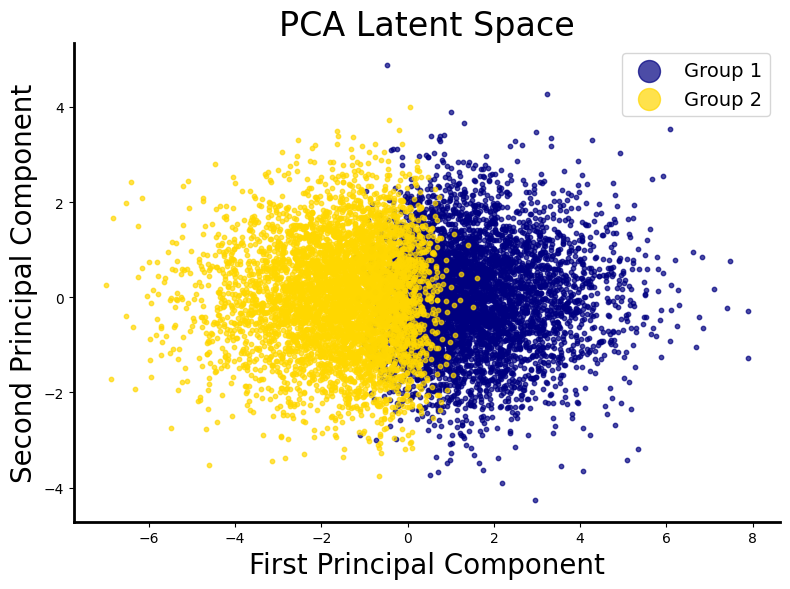

In [6]:
plot_pca_latent_space(S_pca,group_idx)

Note that there is a clear division between the two groups in the first component (which we have designed to contain all of the information relevant to the confounding variables). As a result, any version of PCA which focuses on reconstructing the variance will be highly predictive of the confounding variables.

## Fit adversarial principal component analysis

We now fit our custom analysis

In [7]:
model_adversarial = PPCAadversarial(2,mu=10000.0,regularization="QuadraticInverse")
model_adversarial.fit(X,Y)
S_adv = model_adversarial.transform(X)

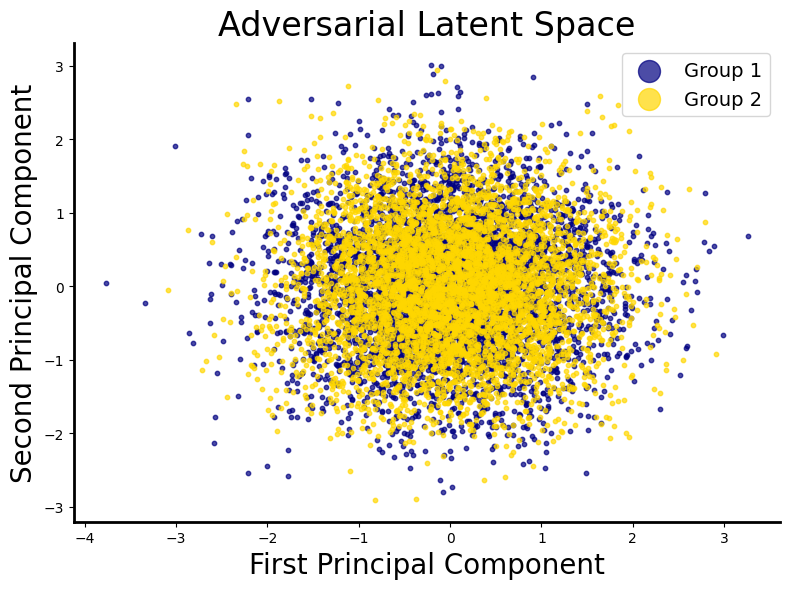

In [8]:
plot_pca_latent_space(S_adv,group_idx,title='Adversarial Latent Space')

## 1000 Genomes Data

We now illustrate how this can be used to remove ancestry from the components learned off of the dosage matrix. This is done with chromosome 22 but it can easily be done with everything with some caviots.

### Load the data

In [9]:
df_dosage = pd.read_feather('/media/austin/ThickBoy__1/Data100Genomes/output2.feather')
dosage_matrix = df_dosage.iloc[:,1:].to_numpy()


### Now we need to generate the confounding variables. In this case, it's a one-hot matrix encoding ancestry. Note that we should demean the covariates.

In [10]:
csv_file_path = './sample_population_ancestry.csv'
df = pd.read_csv(csv_file_path)

# Perform one-hot encoding of the 'Geographical_Ancestry' column
one_hot_df = pd.get_dummies(df, columns=['Geographical_Ancestry'], prefix='Ancestry')

In [11]:
def one_hot_encoder_based_on_samples(sample_names, one_hot_df):
    # Ensure sample names are in the same order and format as in one_hot_df
    # Find the rows in one_hot_df corresponding to the sample names
    filtered_df = one_hot_df[one_hot_df['Sample'].isin(sample_names)]
    
    # Sort to match the order of the sample_names index
    filtered_df = filtered_df.set_index('Sample').loc[sample_names]
    
    # Extract the one-hot encoded values (drop 'Population' column)
    one_hot_encoded_matrix = filtered_df.drop(columns=['Population']).values
    
    return one_hot_encoded_matrix

In [12]:
one_hot_new = one_hot_encoder_based_on_samples(df_dosage.columns[1:],one_hot_df)
one_hot_new = one_hot_new - np.mean(one_hot_new,axis=0)

In [13]:
maf = 0.05
sums_dosage = np.mean(dosage_matrix,axis=1)
dosage_subset = dosage_matrix[sums_dosage>maf].T

### Small data
In the first demonstration we use the standard PCA algorithm, but since this struggles with massive datasets we can't use the entire chromosome. We compare to standard PCA again.

In [14]:
dosage_subset = dosage_subset[:,:10000]

In [15]:
model_pca_chr22 = PCA(2)
S_22_pca = model_pca_chr22.fit_transform(dosage_subset)

In [25]:
one_hot_integer = one_hot_encoder_based_on_samples(df_dosage.columns[1:],one_hot_df)


Text(0.5, 1.0, 'Chromosome 22 PCA Latent Space')

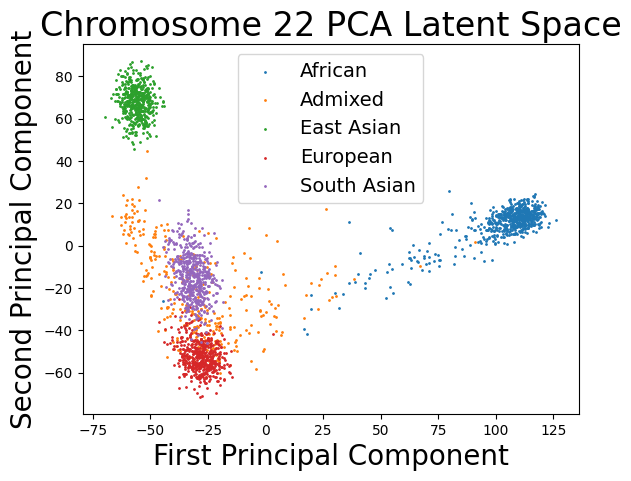

In [26]:
plt.scatter(S_22_pca[one_hot_integer[:,0]==1,0],S_22_pca[one_hot_integer[:,0]==1,1],s=1,label='African')
plt.scatter(S_22_pca[one_hot_integer[:,1]==1,0],S_22_pca[one_hot_integer[:,1]==1,1],s=1,label='Admixed')
plt.scatter(S_22_pca[one_hot_integer[:,2]==1,0],S_22_pca[one_hot_integer[:,2]==1,1],s=1,label='East Asian')
plt.scatter(S_22_pca[one_hot_integer[:,3]==1,0],S_22_pca[one_hot_integer[:,3]==1,1],s=1,label='European')
plt.scatter(S_22_pca[one_hot_integer[:,4]==1,0],S_22_pca[one_hot_integer[:,4]==1,1],s=1,label='South Asian')
plt.legend(loc='upper center',fontsize=14)
plt.xlabel('First Principal Component',fontsize=20)
plt.ylabel('Second Principal Component',fontsize=20)
plt.title('Chromosome 22 PCA Latent Space',fontsize=24)


Clear ancestry information in the latent space

In [17]:
dosage_subset_dm = dosage_subset - np.mean(dosage_subset,axis=0)

### Now adversarial

In [18]:
model_adversarial_chr22 = PPCAadversarial(2,mu=10000.0,regularization="Empirical")
model_adversarial_chr22.fit(dosage_subset_dm,one_hot_new)
S_22_adv = model_adversarial_chr22.transform(dosage_subset_dm)

Text(0.5, 1.0, 'Chromosome 22 PCA Latent Space')

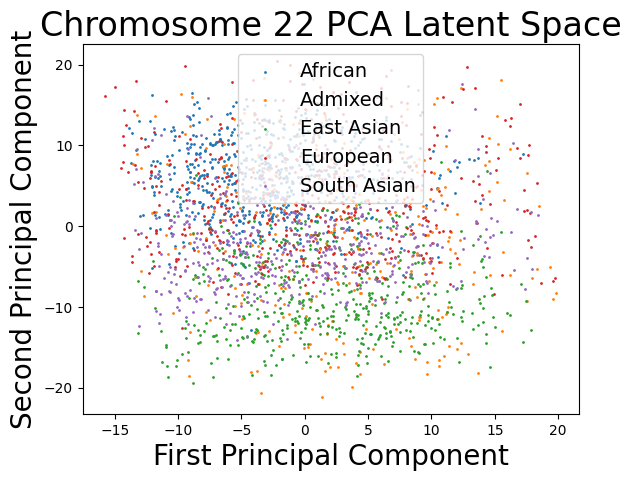

In [27]:
plt.scatter(S_22_adv[one_hot_integer[:,0]==1,0],S_22_adv[one_hot_integer[:,0]==1,1],s=1,label='African')
plt.scatter(S_22_adv[one_hot_integer[:,1]==1,0],S_22_adv[one_hot_integer[:,1]==1,1],s=1,label='Admixed')
plt.scatter(S_22_adv[one_hot_integer[:,2]==1,0],S_22_adv[one_hot_integer[:,2]==1,1],s=1,label='East Asian')
plt.scatter(S_22_adv[one_hot_integer[:,3]==1,0],S_22_adv[one_hot_integer[:,3]==1,1],s=1,label='European')
plt.scatter(S_22_adv[one_hot_integer[:,4]==1,0],S_22_adv[one_hot_integer[:,4]==1,1],s=1,label='South Asian')
plt.legend(loc='upper center',fontsize=14)
plt.xlabel('First Principal Component',fontsize=20)
plt.ylabel('Second Principal Component',fontsize=20)
plt.title('Chromosome 22 PCA Latent Space',fontsize=24)


## Now full dosage matrix

In [20]:
dosage_full = dosage_matrix[sums_dosage>maf].T
model_pca_chr22 = PCA(2)
S_22_pca = model_pca_chr22.fit_transform(dosage_full)

Text(0.5, 1.0, 'Chromosome 22 PCA Latent Space')

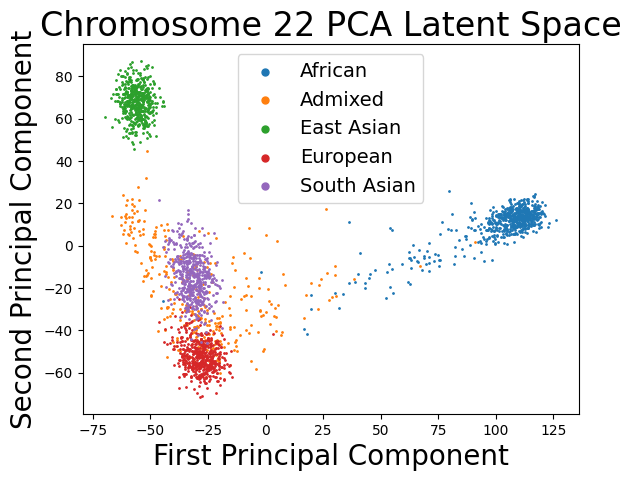

In [28]:
plt.scatter(S_22_pca[one_hot_integer[:,0]==1,0],S_22_pca[one_hot_integer[:,0]==1,1],s=1,label='African')
plt.scatter(S_22_pca[one_hot_integer[:,1]==1,0],S_22_pca[one_hot_integer[:,1]==1,1],s=1,label='Admixed')
plt.scatter(S_22_pca[one_hot_integer[:,2]==1,0],S_22_pca[one_hot_integer[:,2]==1,1],s=1,label='East Asian')
plt.scatter(S_22_pca[one_hot_integer[:,3]==1,0],S_22_pca[one_hot_integer[:,3]==1,1],s=1,label='European')
plt.scatter(S_22_pca[one_hot_integer[:,4]==1,0],S_22_pca[one_hot_integer[:,4]==1,1],s=1,label='South Asian')
plt.legend(loc='upper center', fontsize=14, scatterpoints=1, markerscale=5)
plt.xlabel('First Principal Component',fontsize=20)
plt.ylabel('Second Principal Component',fontsize=20)
plt.title('Chromosome 22 PCA Latent Space',fontsize=24)


It's now even clearer 

In [29]:
dosage_full_dm = dosage_full - np.mean(dosage_full,axis=0)

In [30]:
model_adversarial_chr22 = PPCAadversarialRandomized(2,mu=1000000.0)
model_adversarial_chr22.fit(dosage_full_dm,one_hot_new)


In [31]:
S_new = np.dot(dosage_full_dm,model_adversarial_chr22.W_.T)

Text(0.5, 1.0, 'Chromosome 22 PCA Latent Space')

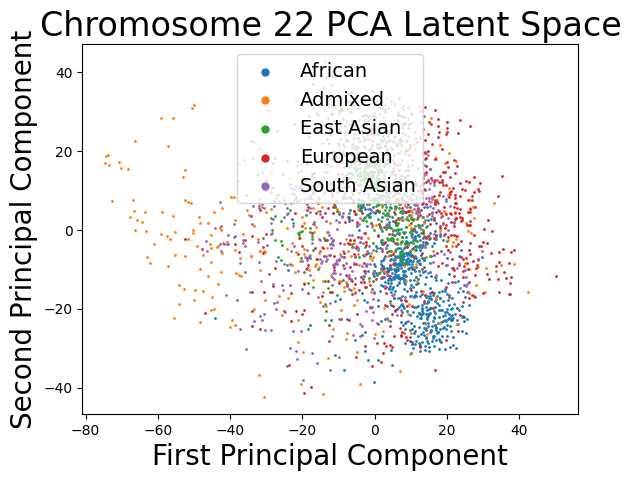

In [32]:
plt.scatter(S_new[one_hot_integer[:,0]==1,0],S_new[one_hot_integer[:,0]==1,1],s=1,label='African')
plt.scatter(S_new[one_hot_integer[:,1]==1,0],S_new[one_hot_integer[:,1]==1,1],s=1,label='Admixed')
plt.scatter(S_new[one_hot_integer[:,2]==1,0],S_new[one_hot_integer[:,2]==1,1],s=1,label='East Asian')
plt.scatter(S_new[one_hot_integer[:,3]==1,0],S_new[one_hot_integer[:,3]==1,1],s=1,label='European')
plt.scatter(S_new[one_hot_integer[:,4]==1,0],S_new[one_hot_integer[:,4]==1,1],s=1,label='South Asian')
plt.legend(loc='upper center', fontsize=14, scatterpoints=1, markerscale=5)

plt.xlabel('First Principal Component',fontsize=20)
plt.ylabel('Second Principal Component',fontsize=20)
plt.title('Chromosome 22 PCA Latent Space',fontsize=24)
